In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import scipy
from tqdm.notebook import tqdm

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

import sys
sys.path.insert(1, '../src')
from mylogbin import mylogbin, fit_se

font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

In [2]:
estats = pd.read_csv('../data/figure_1/EditorStats.csv',sep='\t',
                     dtype={'Parent':int,'Year0':int,'EPriorPaperCount':int,'EPriorCitationCount':int,
                            'EHindex':int,'ETop':bool,'EColabCount':int,'Age':int})

astats = pd.read_csv('../data/figure_1/AuthorStats.csv',sep='\t',
                     dtype={'Parent':int,'Year0':int,'APriorPaperCount':float,'APriorCitationCount':float,
                            'AHindex':float,'ATop':float,'AColabCount':float})

### Log-log distribution
#### Supplementary figure 1

In [3]:
def plotOutcome(ax, outcome):
    plt.xscale('log')
    plt.yscale('log')
    a = astats['A'+outcome].to_numpy()
    x, h = mylogbin(a,base)
    plt.plot(x,h,marker='x',ls='None',markersize=2,color='#4daf4a',linewidth=1)

    a = estats['E'+outcome].to_numpy()
    x, h = mylogbin(a,base)
    plt.plot(x,h,marker='o',ls='None',markersize=2,color='#377eb8',linewidth=1)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

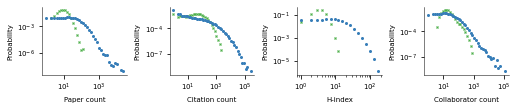

In [4]:
base = 1.3
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(18.3*cm, 4*cm))

ax = plt.subplot(1, 4, 1)
plotOutcome(ax, 'PriorPaperCount')
ax.set_xlabel('Paper count')
ax.set_ylabel('Probability')

ax = plt.subplot(1, 4, 2)
plotOutcome(ax, 'PriorCitationCount')
ax.set_xlabel('Citation count')
ax.set_ylabel('Probability')

ax = plt.subplot(1, 4, 3)
plotOutcome(ax, 'Hindex')
ax.set_xlabel('H-index')
ax.set_ylabel('Probability')

ax = plt.subplot(1, 4, 4)
plotOutcome(ax, 'ColabCount')
ax.set_xlabel('Collaborator count')
ax.set_ylabel('Probability')

plt.tight_layout()
#plt.savefig('../figures/sup_1_loglog.pdf', bbox_inches = 'tight', pad_inches = 0)

### Breakdown into disciplines
#### Supplementary Figure 2 - 6

In [5]:
def plotPvalue(ax, x, y, pVal, ytop, lw=0.2, c='black'):
    # x: [x0, x1]
    # y: [y0, y1]
    height = max(y[0], y[1])
    gap = ytop * 0.05
    vlength = ytop * 0.03
    
    yPos = height + gap + vlength
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], height + gap, yPos, color=c, lw=lw)
    ax.vlines(x[1], height + gap, yPos, color=c, lw=lw)
    
    stars = '***' if pVal < 0.001 else '**' if pVal < 0.01 else '*' if pVal < 0.05 else f'p={round(pVal, 2)}'
    offset = 0.01 if pVal < 0.05 else 0.04
    
    ax.text((x[0] + x[1])/2, yPos + offset*ytop, stars, ha='center', color=c)

In [6]:
def plotBox(ax, ys, ytop, confidence=0.95, showP=True):
    colors = ['#4daf4a', '#377eb8']
    
    p_value = scipy.stats.ttest_ind(ys[0], ys[1], permutations=1000)
    
    x = [i+1 for i in range(len(ys))]
    
    box1 = ax.boxplot(ys[0], positions = [1], showfliers=False, showmeans=True, widths=0.6, patch_artist=True,
                      whis = [5, 95],
               meanprops = dict(marker='x', markerfacecolor='#4daf4a', markersize=3, 
                                markeredgecolor='#4daf4a', markeredgewidth=1.5),
              boxprops = dict(linewidth=0.4, facecolor=(0.3, 0.69, 0.29, 0.2)),
               whiskerprops = dict(linewidth=0.2),
              capprops = dict(linewidth=0.2),
            medianprops = dict(linewidth=0.4))
    
    top1 = max([_.get_ydata()[0] for _ in box1['caps']])
    
    box2 = ax.boxplot(ys[1], positions = [2], showfliers=False, showmeans=True, widths=0.6, patch_artist=True,
                      whis = [5, 95],
               meanprops = dict(marker='o', markerfacecolor='#377eb8', markersize=3,
                                markeredgecolor='#377eb8'),
              boxprops = dict(linewidth=0.4, facecolor=(0.216, 0.494, 0.72, 0.2)),
               whiskerprops = dict(linewidth=0.2),
               capprops = dict(linewidth=0.2),
                medianprops = dict(linewidth=0.4))
    
    top2 = max([_.get_ydata()[0] for _ in box2['caps']])
    
    top = max(top1, top2)
    
    plotPvalue(ax, x, [top, top], p_value.pvalue, top)
    
    return box1, box2

In [7]:
def calcBoxHeight(l):
    a, b = l
    
    return max(np.percentile(a, 95), np.percentile(b, 95))

In [8]:
def plotBar(ax, ys, ytop, confidence=0.95, showP=True, ttest=True):
    colors = [(0.3, 0.69, 0.29, 0.2), (0.216, 0.494, 0.72, 0.2)]
    
    means = [y.mean() for y in ys]
    errs = [st.sem(y)*st.t.ppf((1 + confidence) / 2., y.shape[0]-1) for y in ys]
    if ttest:
        p_value = scipy.stats.ttest_ind(ys[0], ys[1], permutations=1000).pvalue
    else:
        a = ys[0].sum()
        b = ys[0].shape[0]-ys[0].sum()
        
        c = ys[1].sum()
        d = ys[1].shape[0]-ys[1].sum()
        conti = [[a, b], [c, d]]
        res = scipy.stats.fisher_exact(conti)
        p_value = res[1]
        print(conti, res)
    
    x = [i+1 for i in range(len(ys))]
    
    ax.bar(x, means, width = 0.6, yerr=errs, color=colors, error_kw={'elinewidth':0.5}, linewidth=0.2,
           edgecolor=['black','black'])
    
    if showP:
        height = [means[i] + errs[i] for i in range(len(ys))]
        
        plotPvalue(ax, x, height, p_value, max(height))

In [23]:
def plot(outcome):
    cm = 1/2.54  # centimeters in inches
    plt.figure(figsize=(18.3*cm, 16*cm))
    plt.rcParams.update({'font.size': 7, 'axes.linewidth': 1})
    
    max_height = 0
    axes = []
    
    for i in range(3):
        for j in range(5):
            field = top_field.at[i*5+j, 'Field']
            edf = estats[estats.Discipline == field]
            adf = stats[stats.AuthorField == field]
            
            if outcome == 'Top':
#                 maximum = calcHeight([adf['A'+outcome].values, edf['E'+outcome].values])
#                 max_height = max(max_height, maximum)
                max_height = 0.65
            else:
                maximum = calcBoxHeight([adf['A'+outcome].values, edf['E'+outcome].values])
                max_height = max(max_height, maximum)

    for i in range(3):
        for j in range(5):
            field = top_field.at[i*5+j, 'Field']
            edf = estats[estats.Discipline == field]
            adf = stats[stats.AuthorField == field]
            
            ax = plt.subplot(3, 5, i*5+j+1)
            ax.set_title(field, fontsize=11, fontweight='bold')
            axes.append(ax)
            
            if outcome == 'Top':
                plotBar(ax, [adf['A'+outcome].values, edf['E'+outcome].values], ytop=max_height)
            else:
                plotBox(ax, [adf['A'+outcome].values, edf['E'+outcome].values], ytop=max_height)
            
            ax.set_xticks([1, 2])
            ax.set_xticklabels(['Scientist', 'Editor'])

            ax.set_ylabel(ylabels[outcome])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            
            ax.tick_params(axis='x', length=0)
            
    for ax in axes:
        if outcome != 'Top':
            ax.set_ylim(max_height*-0.02, max_height*1.1)
        else:
            ax.set_ylim(0, max_height*1.05)
        
        ax.spines['left'].set_bounds(0, max_height*1.05)

    plt.tight_layout()
    
    plt.savefig(f"../figures/sup_1_{outcome}.pdf", bbox_inches = 'tight', pad_inches = 0)

In [16]:
top_field = (
    pd.read_csv('../data/supplementary/AllFields.csv', sep='\t',
                dtype={'Discipline':str, 'FieldOfStudyId':int})
    .rename(columns={'FieldOfStudyId':'Parent','Discipline':'Field'})
    .sort_values(by='Field')
    .reset_index(drop=True)
)

In [17]:
outcomes = ["PriorPaperCount",
           'PriorCitationCount',
           "Hindex",
           'ColabCount',
          'Top']

ylabels = {"PriorPaperCount":'Paper Count',
           'PriorCitationCount':'Citation Count',
           "Hindex":'H-index',
           'ColabCount':'Collaborator count',
          'Top':'Top-100 affiliation'}

In [18]:
stats = pd.read_csv('../data/figure_1/AuthorIndividualStats.csv',sep='\t',
                     dtype={'AuthorField':str,'Year0':int,'APriorPaperCount':float,'APriorCitationCount':float,
                            'AHindex':float,'ATop':float,'AColabCount':float})
estats = pd.read_csv('../data/figure_1/EditorStats.csv',sep='\t',
                     dtype={'Parent':int,'Year0':int,'EPriorPaperCount':int,'EPriorCitationCount':int,
                            'EHindex':int,'ETop':bool,'EColabCount':int,'Age':int})

CPU times: user 2min 12s, sys: 44 s, total: 2min 56s
Wall time: 2min 57s


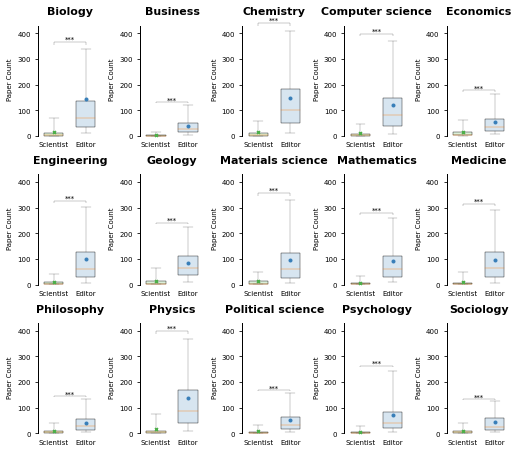

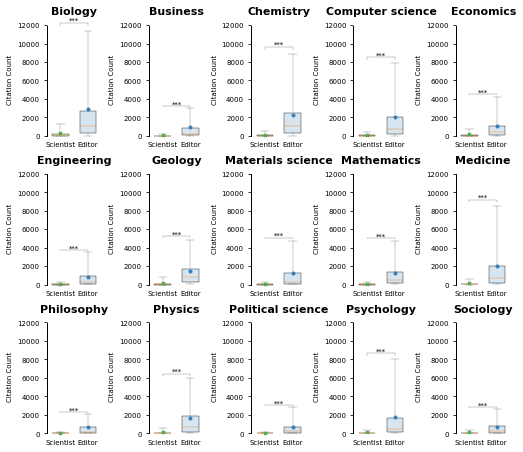

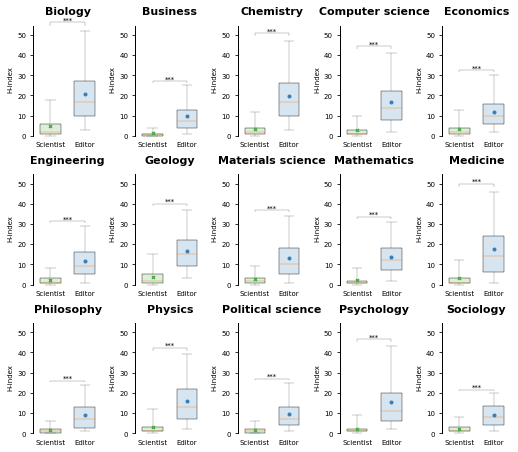

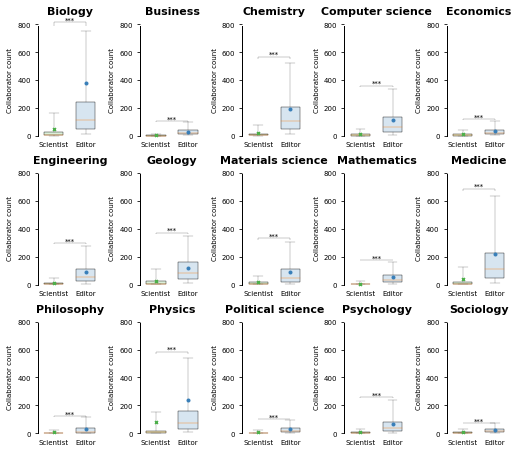

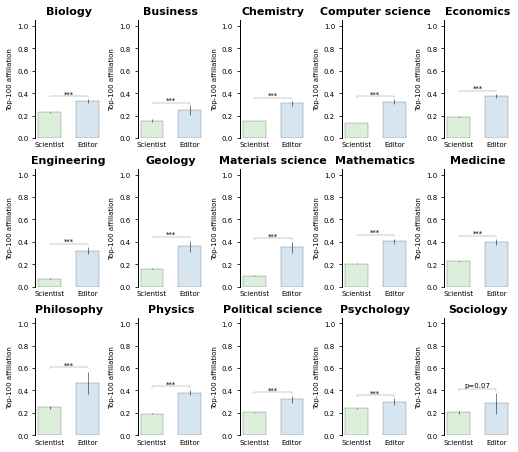

In [19]:
%%time
for outcome in outcomes:
    plot(outcome)

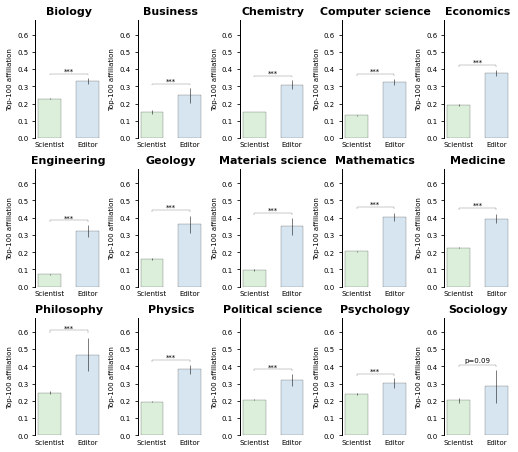

In [24]:
plot('Top')

### Excluding Biology
#### Supplementary Figure 7

In [19]:
def meanCI(a, conf=0.95):
    mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
    return mean, sem*1.96

def plot_dots(df, outcome, ax, style, c, x_min=1980, x_max=2017):
    for year in range(x_min, x_max+1):
        sub = df[df.Year0 == year]
        if sub.shape[0] <=1:
            continue
        v = sub[outcome].values
        
        me, sem = meanCI(v, 0.95)
        ax.errorbar(year, me, yerr=sem, color=c, fmt=style, elinewidth=0.5, ms=2)

def plotTemporal(ax, a, e, ylim, astats, estats, bio=None):
    if bio:
        astats = astats.query('Parent == 86803240')
        estats = estats.query('Parent == 86803240')
    elif bio == False:
        astats = astats.query('Parent != 86803240')
        estats = estats.query('Parent != 86803240')
    else:
        assert(bio == None)
    
    if a is not None:
        plot_dots(astats, a, ax, 'd', '#4daf4a') # author
    plot_dots(estats, e, ax, 'o', '#377eb8')
    
    ax.set_xticks([1980,1990,2000,2010])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(b=True, ls=':')
    ax.set_ylim(0, ylim)

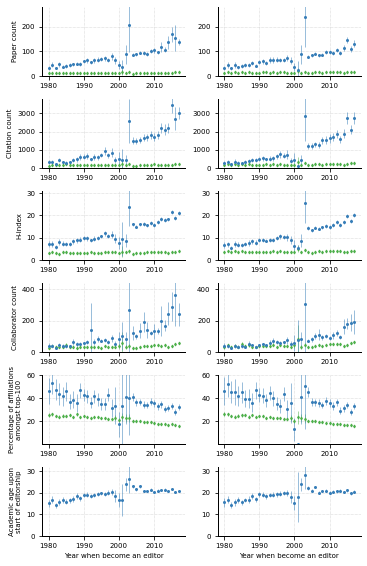

In [21]:
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(13*cm, 20*cm))

outcomes = [['APriorPaperCount','EPriorPaperCount'],
            ['APriorCitationCount','EPriorCitationCount'],
            ['AHindex','EHindex'],        
            ['AColabCount','EColabCount'],
           ['ATop','ETop'],
           [None, 'Age']]

#ylims = [220, 4000, 32, 420, 0.8, 32]
ylims = [280, 3800, 31, 440, 0.6, 32]

axes = [plt.subplot(6, 2, row*2 + col+1) for row in range(6) for col in range(2) ]

for i in range(6):
    plotTemporal(axes[i*2], *outcomes[i], ylims[i], astats, estats, bio=None)
    plotTemporal(axes[i*2+1], *outcomes[i], ylims[i], astats, estats, bio=False)
    #plotTemporal(axes[i*3+2], *outcomes[i], ylims[i], astats, estats, bio=True)
    
axes[0].set_ylabel('Paper count')
axes[1*2].set_ylabel('Citation count')
axes[2*2].set_ylabel('H-index')
axes[3*2].set_ylabel('Collaborator count')
axes[4*2].set_ylabel('Percentage of affiliations\namongst top-100')
axes[5*2].set_ylabel('Academic age upon\nstart of editorship')

for i in range(8, 10):
    axes[i].set_yticks([0.2, 0.4, 0.6])
    axes[i].set_yticklabels(['20', '40', '60'])
    
for i in range(10, 12):
    axes[i].set_xlabel('Year when become an editor')

plt.tight_layout()
plt.savefig('../figures/sup_1_trend_bio_nobio.pdf', bbox_inches = 'tight', pad_inches = 0)